# Three steps to prepare a session:
1. Submit local PDB file
2. Submit local MOL2 file
3. Submit session preparation request

# Batch Preparation

In [5]:
import pandas as pd 
from os import path 
from BetaPose import session_prep
import json, time, re

Template = {
  "jobid"    : "XXXXXXXX", 
  "pdbcode"  : "XXXX", 
  "pdbfile"  : "/tmp/tmp.pdb", 
  "mol2file" : "/tmp/tmp.mol2",
  "nrsteps"  : 100,
  'pdb_tolerance_a': '50.0',
  'pdb_tolerance_b': '0.5 1.5',
}
csvfile = "/home/miemie/Dropbox/Documents/BetaPose/test142.csv"
table = pd.read_csv(csvfile, index_col=0); 
basepath = "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined"


def prepit(pdbcode):
  time.sleep(int(time.perf_counter().__str__()[-3:])/3000);
  pdbcode = pdbcode.lower(); 
  thesubmission = {i:j for i,j in Template.items()}; 
  thesubmission["pdbcode"] = pdbcode.upper(); 
  
  pdbfile  = f"{basepath}/{pdbcode}/{pdbcode}_protein.pdb"; 
  mol2file = f"{basepath}/{pdbcode}/{pdbcode}_ligand.mol2"; 
  
  # Preprocess PDB file: 
  # E.G. Switch from CSO to CYS; 
  with open(pdbfile, "r") as file1:
    pdbstr = file1.read(); 
    if re.search("CSO", pdbstr):
      print(f"Found CSO residue", pdbcode); 
      pdbstr = pdbstr.replace("CSO", "CYS")
      preprocessed = f"{basepath}/{pdbcode}/{pdbcode}_processed.pdb"; 
      with open(preprocessed, "w") as file2:
        file2.write(pdbstr)
        pdbfile = preprocessed; 
  
  if path.isfile(pdbfile) and path.isfile(mol2file): 
    thesubmission["jobid"]    = f"C400{pdbcode.upper()}"
    thesubmission["pdbfile"]  = pdbfile;
    thesubmission["mol2file"] = mol2file;
    session_prep.PrepNewSession(thesubmission); 
    session_prep.RunSimpleEquil(thesubmission["jobid"], nrsteps=100)
    session_prep.EquilToSession(thesubmission["jobid"], nrsteps=100)
  elif not path.isfile(mol2file):
    print(f"Cannot find the ligand MOL2 file: {mol2file}")
  elif not path.isfile(pdbfile):
    print(f"Cannot find the protein PDB file: {pdbfile}")
  return thesubmission
# do_it("1Y6Q")

In [15]:
import time

def prepone(pdbcode):
  """
    Preprocess the PDB file for success preparation
  """
  time.sleep(int(time.perf_counter().__str__()[-3:])/3000);
  pdbcode = pdbcode.lower(); 
  thesubmission = {i:j for i,j in Template.items()}; 
  thesubmission["pdbcode"] = pdbcode.upper(); 
  
  pdbfile = path.join(bpath, f"{pdbcode}/{pdbcode}_protein.pdb"); 
  mol2file = path.join(bpath, f"{pdbcode}/{pdbcode}_ligand.mol2"); 
  
  # Preprocess PDB file: 
  # E.G. Switch from CSO to CYS; 
  with open(pdbfile, "r") as file1:
    pdbstr = file1.read(); 
    if re.search("CSO", pdbstr):
      print(f"Found CSO residue", pdbcode); 
      pdbstr = pdbstr.replace("CSO", "CYS")
      preprocessed = path.join(bpath, f"{pdbcode}/{pdbcode}_processed.pdb"); 
      with open(preprocessed, "w") as file2:
        file2.write(pdbstr)
        pdbfile = preprocessed; 
    if re.search("HOH", pdbstr):
      pdbstr = [_ for _ in pdbstr.split("\n") if "HOH" not in _]; 
      pdbstr = "\n".join(pdbstr)
      preprocessed = path.join(bpath, f"{pdbcode}/{pdbcode}_processed.pdb"); 
      with open(preprocessed, "w") as file2:
        file2.write(pdbstr); 
        pdbfile = preprocessed; 
  
  if path.isfile(pdbfile) and path.isfile(mol2file): 
    thesubmission["jobid"]    = f"C400{pdbcode.upper()}"
    print(pdbfile)
    pdb_state = session_prep.SubmitPDB(pdbfile, "C400TEST", pdbcode=pdbcode, water="T3P");
    mol2_state = session_prep.SubmitMOL2(mol2file, "C400TEST");
prepone("1swr")

/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/1swr/1swr_processed.pdb


# Do multi-processing to prepare sessions in parallel; 

In [2]:
import multiprocessing as mp; 
import time; 

csvfile = "/home/miemie/Dropbox/Documents/BetaPose/test142.csv"; 
table = pd.read_csv(csvfile, index_col=0); 


target_pdbs = table.PDB
print(target_pdbs)

pool = mp.Pool(16);
results = pool.starmap(prepit, [(i,) for i in target_pdbs]);
pool.close();
pool.join();
with open("/home/miemie/Dropbox/Documents/BetaPose/tests/test142.json", "w") as file1: 
  json.dump(results, file1)

0      1mq5
1      2idw
2      1swg
3      1gpn
4      1ws4
       ... 
137    3d7z
138    2psv
139    3f8f
140    1ele
141    1hmt
Name: PDB, Length: 142, dtype: object
Preparing the session C4007STD ; PDB code:  C4007STD
Preparing the sessionPreparing the session  C4001FH9C4003B67   ; PDB code: ; PDB code: C4001FH9
 C4003B67
Preparing the session C4002CSN ; PDB code:  C4002CSN
Preparing the session C4001F4E ; PDB code:  C4001F4E
Preparing the session C4002O4J ; PDB code:  C4002O4J
Preparing the session C4001F4G ; PDB code:  C4001F4G
Preparing the sessionPreparing the session  C4001SWRC4001JET  ; PDB code: ; PDB code:   C4001JETC4001SWR

Preparing the session C4001UWF ; PDB code:  C4001UWF
Preparing the session C4003B68 ; PDB code:  C4003B68
Preparing the session C4001MQ5 ; PDB code:  C4001MQ5
Preparing the session C4002FLR ; PDB code:  C4002FLR
Preparing the session C4001DHI ; PDB code:  C4001DHI
Preparing the session C4001GPN ; PDB code:  C4001GPN
Preparing the session C4001Q65 ; PD

Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4002IDW
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001ERB
Finished the running of equilibration job:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the running of equilibration job:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"

System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4002QE4
Preparing the session C4001Y6Q ; PDB code:  C4001Y6Q
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4002A8G
Finished the running of equilibration job:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB

Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4002OXX
Preparing the session C4003F8C ; PDB code:  C4003F8C
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4005ER1
Preparing the session C4003BEX ; PDB code:  C4003BEX
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4001V2R
Preparing the session C4001G74 ; 

Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001UGX
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4003DJK
Preparing the session C4002CGF ; PDB code:  C4002CGF
Finished the running of equilibr

Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4001N46
Preparing the session C4001V0L ; PDB code:  C4001V0L
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001NO6
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001N4H
Finished the running of equilibration job:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fc

Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4002QBQ
Preparing the session C4002FQX ; PDB code:  C4002FQX
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-b

Finished the preparation of session  C4003B66
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the running of equilibration job:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the re-preparation of session C4001VYF
Preparing the session C4002J7G ; PDB code:  C4002J7G
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of se

Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4002EXM
Finished the running of equilibration job:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001K4H
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Fi

In [12]:
# with open("test142.json", "w") as file1: 
#   json.dump(results, file1, indent=2)
session_prep.EquilToSession("C4003D7Z", nrsteps=100)


Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Equilbrated structure retrieval exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi


NameError: name 're' is not defined

# Evaluate the prepared structure. 

In [2]:
import pandas as pd
from BetaPose import utils, session_prep
import numpy as np 

csvfile = "/home/miemie/Dropbox/Documents/BetaPose/test142.csv"; 
table = pd.read_csv(csvfile, index_col=0); 

def exp(code):
  return f"C400{code.upper()}"

tmscores = []
sessions = []
dist_after = []
for i in table.PDB:
  sessid = exp(i);
  try: 
    score = utils.CompareStructures(i, sessexp=exp); 
    if score > 0.8: 
      print(f"{exp(i)}: Good Score {score:>8.3f} | ", end="")
    else:
      print(f"{exp(i)}: Bad  Score {score:>8.3f} | ", end="")
    tmscores.append(score); 
    sessions.append(sessid); 
    
  except Exception as e: 
    print(f"{exp(i)}: Warning, failed to compute the TM-score of the session ")
    tmscores.append(0)
    sessions.append(sessid)
    
  try: 
    dist = utils.DistanceLigPro(sessid, mode="session")
    dist_after.append(dist)
    dist_before = table[table.PDB == i]["distB"].item()
    print(f"{dist_before:>8.3f} | {dist:>8.3f} | {abs(dist_before-dist):>8.3f}")
  except Exception as e: 
    dist_after.append(999)
    
if len(tmscores) == len(table): 
  table["TMScore"] = tmscores
if len(sessions) == len(table): 
  table["sess_id"] = sessions
if len(dist_after) == len(table): 
  table["distA"] = dist_after
  

# 2 Sessions are failed "C4003D83_err" "C4002PVK_err"


C4001MQ5: Good Score    1.000 |   17.424 |   17.423 |    0.001
C4002IDW: Good Score    1.000 |    4.885 |    5.227 |    0.342
C4001SWG: Good Score    0.810 |   15.243 |   16.926 |    1.683
C4001GPN: Good Score    0.919 |    7.820 |    9.823 |    2.003
C4001WS4: Good Score    1.000 |   35.713 |   35.837 |    0.124
C4001LPZ: Good Score    1.000 |   13.503 |   13.487 |    0.016
C4001SWR: Bad  Score    0.661 |   15.265 |  549.136 |  533.872
C4002A8G: Good Score    0.992 |   15.158 |   15.851 |    0.693
C4001Y3N: Good Score    1.000 |    6.173 |    5.651 |    0.521
C4007STD: Good Score    1.000 |   17.804 |   17.677 |    0.127
C4001FKI: Good Score    1.000 |   20.096 |   19.938 |    0.158
C4001XK9: Good Score    0.999 |    8.473 |    8.315 |    0.158
C4001UWF: Good Score    1.000 |   22.218 |   22.190 |    0.029
C4001QBO: Good Score    1.000 |   13.878 |   13.462 |    0.416
C4002JDS: Good Score    1.000 |    8.919 |    9.025 |    0.106
C4002CSN: Good Score    0.976 |   11.691 |   11.832 |  

RDKit ERROR: [17:33:46] 
[17:33:46] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[17:33:46] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[17:33:46] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[17:33:50] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[17:34:15] 

****
Post-cond

C4002QBU: Good Score    0.999 |   11.278 |   11.485 |    0.207
C4001TD7: Good Score    1.000 |    7.656 |   14.383 |    6.727
C4001OYQ: Good Score    1.000 |   14.739 |   14.664 |    0.075
C4001P1O: Good Score    0.992 |   15.629 |   15.441 |    0.188
C4001O5E: Bad  Score    0.465 |   19.670 | 1384.235 | 1364.565
C4001K4H: Good Score    0.999 |    7.637 |    8.536 |    0.899
C4001EJN: Good Score    1.000 |   10.041 |    9.995 |    0.046
C4002STD: Good Score    0.963 |   18.139 |   18.387 |    0.249
C4002C3L: Good Score    0.845 |   13.379 |   28.596 |   15.217
C4001OD8: Good Score    0.997 |    9.803 |   10.134 |    0.331
C4001ZOG: Good Score    0.963 |   30.232 |   30.141 |    0.091
C4002P7Z: Good Score    1.000 |   11.624 |   11.157 |    0.467
C4001LKE: Bad  Score    0.724 |    6.576 |   10.973 |    4.397
C4001LEE: Good Score    1.000 |    8.314 |    8.528 |    0.214
C4002V95: Bad  Score    0.421 |   16.207 |   39.405 |   23.197
C4003B66: Good Score    1.000 |    8.583 |    8.618 |  

In [9]:
# table
# with open(csvfile, "w") as file1: 
#   file1.write(table.to_csv())

table[table.PDB == i]["distB"].item()

27.84475701448862

      PDB  resolution  year  affinity       kd/ki  embedding_factor  \
0    1mq5        2.10  2003      9.00      Ki=1nM          0.793933   
1    2idw        1.10  2006      8.89    Ki=1.3nM          0.899889   
2    1swg        1.80  1998      7.36   Kd=43.9nM          0.832940   
3    1gpn        2.35  2002      6.48  Ki=0.334uM          0.979791   
4    1ws4        1.90  2005      3.00   Kd=1.00mM          0.709806   
..    ...         ...   ...       ...         ...               ...   
103  2boh        2.20  2006      8.52      Ki=3nM          0.832182   
104  3d7z        2.10  2008      7.92     Ki=12nM          0.971609   
105  2psv        1.75  2007      7.24     Ki=58nM          0.927222   
106  1ele        2.00  1995      6.85   Ki=0.14uM          0.704402   
107  1hmt        1.40  1995      5.79   Kd=1.64uM          0.771558   

     complex_nha  lig_nha      distB  \
0           2427       34  17.424027   
1           1803       38   4.884697   
2           3812       16  

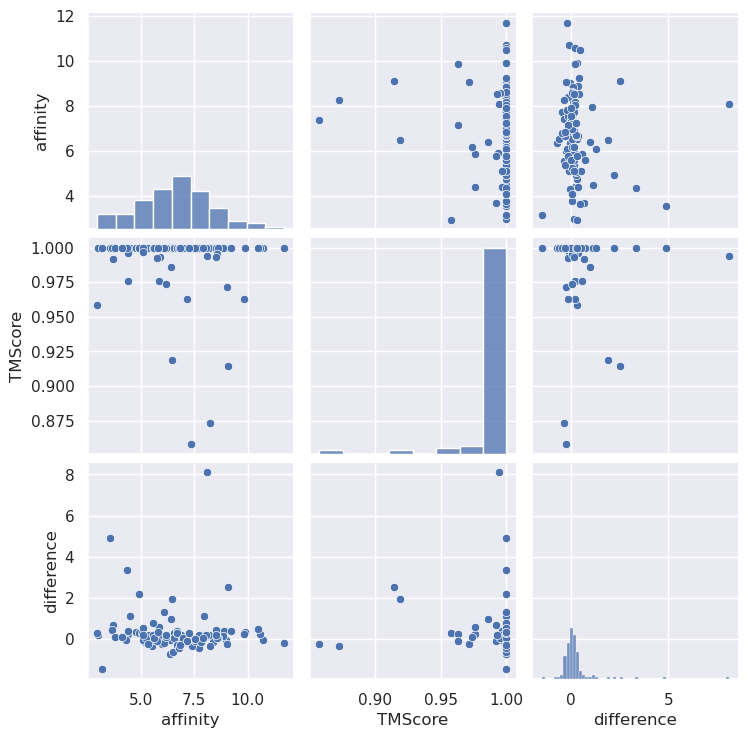

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(); 

csvfile = "/home/miemie/Dropbox/Documents/BetaPose/test142.csv"; 
table = pd.read_csv(csvfile, index_col=0); 

table["difference"] = table.distA-table.distB
table = table

st = (table.TMScore > 0.85) * (table.difference < 10)
# st = (table.difference > 4) * (table.difference < 10)
table_2 = table[st]
table_2 = table_2.reset_index(drop=1)
print(table_2)
print(len(table_2))

cols = table_2[["affinity", "TMScore", "difference"]] 
sns.pairplot(cols)

In [5]:
csvfile = "/home/miemie/Dropbox/Documents/BetaPose/AfterPrep_108_142.csv"; 
with open(csvfile, "w") as file1: 
  file1.write(table_2.to_csv())